In [1]:
!pip install --upgrade numba sktime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.5/35.5 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninstalled numba-0.60.0


In [2]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sktime.transformations.panel.rocket import (
    MiniRocket,
    MiniRocketMultivariate,
    MiniRocketMultivariateVariable,
)

In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the data
df_PMData = pd.read_csv('/content/PMData_features_vector.csv')
df_PMData .head()
# Select features and label
features = ['steps', 'sedentary', 'LPA', 'MPA', 'VPA']
X = df_PMData [features]
y = df_PMData ['active']

# Convert the feature DataFrame to the nested format required by sktime
#X = X.apply(lambda x: pd.Series(x.values), axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the head of the training features and labels
display(X_train.head())
display(y_train.head())

,steps,sedentary,LPA,MPA,VPA
478,10338.0,670,281,4,18
1247,3619.0,656,138,6,2
2100,2177.0,740,80,8,4
629,14021.0,652,206,36,64
1040,9040.0,585,227,9,6


,active
478,2
1247,0
2100,0
629,4
1040,1


In [5]:
#MiniRocketMultivariate

from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, accuracy_score

# Reshape X_train and X_test to the correct 3D numpy array format (n_samples, n_variables, n_timepoints)
X_train_reshaped = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

# Pad X_train_reshaped and X_test_reshaped with zeros to have at least 9 timepoints
padding_length = 9 - X_train_reshaped.shape[2]
X_train_padded = np.pad(X_train_reshaped, ((0, 0), (0, 0), (0, padding_length)), mode='constant', constant_values=0)
X_test_padded = np.pad(X_test_reshaped, ((0, 0), (0, 0), (0, padding_length)), mode='constant', constant_values=0)


# Create a pipeline with MiniRocketMultivariate and RidgeClassifierCV
minirocket_multivariate_pipeline = make_pipeline(
    MiniRocketMultivariate(num_kernels=10000),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
)

# Fit the pipeline to the training data
minirocket_multivariate_pipeline.fit(X_train_padded, y_train)

# Predict on the test data
y_pred_minirocket_multivariate = minirocket_multivariate_pipeline.predict(X_test_padded)


# Calculate the accuracy
accuracy_minirocket_multivariate = accuracy_score(y_test, y_pred_minirocket_multivariate)

# Calculate additional metrics
precision_minirocket_multivariate = precision_score(y_test, y_pred_minirocket_multivariate, average='micro')
recall_minirocket_multivariate = recall_score(y_test, y_pred_minirocket_multivariate, average='micro')
f1_minirocket_multivariate = f1_score(y_test, y_pred_minirocket_multivariate, average='weighted')
mcc_minirocket_multivariate = matthews_corrcoef(y_test, y_pred_minirocket_multivariate)


# Print the accuracy
print(f"MiniRocketMultivariate Classifier Accuracy: {accuracy_minirocket_multivariate}")
print(f"MiniRocketMultivariate Classifier Precision: {precision_minirocket_multivariate}")
print(f"MiniRocketMultivariate Classifier Recall: {recall_minirocket_multivariate}")
print(f"MiniRocketMultivariate Classifier F1-score: {f1_minirocket_multivariate}")
print(f"MiniRocketMultivariate Classifier MCC: {mcc_minirocket_multivariate}")

MiniRocketMultivariate Classifier Accuracy: 0.9666666666666667
MiniRocketMultivariate Classifier Precision: 0.9666666666666667
MiniRocketMultivariate Classifier Recall: 0.9666666666666667
MiniRocketMultivariate Classifier F1-score: 0.9666400937323706
MiniRocketMultivariate Classifier MCC: 0.9559880670396643


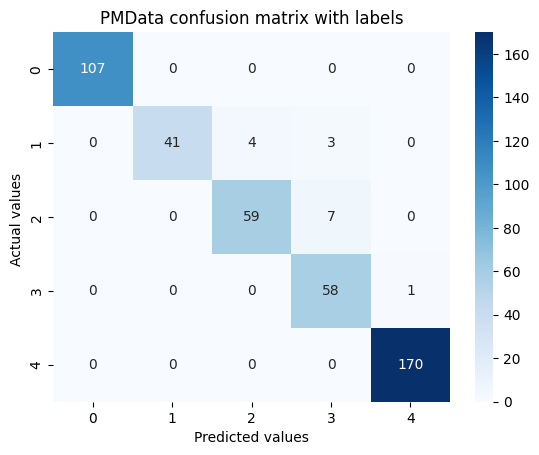

In [11]:
from sklearn.metrics import confusion_matrix

cor = confusion_matrix(y_test, y_pred_minirocket_multivariate)

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cor, annot=True, cmap='Blues', fmt='d')
ax.set_title('PMData confusion matrix with labels')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values ')

fig = ax.get_figure()
fig.savefig('PMData_confusion_minirocket_multivariate.png', dpi=300)
plt.show()

In [12]:
#MiniRocketMultivariateVariable

# Create a pipeline with MiniRocketMultivariateVariable and RidgeClassifierCV
minirocket_multivariate_variable_pipeline = make_pipeline(
    MiniRocketMultivariateVariable(num_kernels=10000),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
)

# Fit the pipeline to the padded training data
minirocket_multivariate_variable_pipeline.fit(X_train_padded, y_train)

# Predict on the padded test data
y_pred_minirocket_multivariate_variable = minirocket_multivariate_variable_pipeline.predict(X_test_padded)

# Calculate the accuracy
accuracy_minirocket_multivariate_variable = accuracy_score(y_test, y_pred_minirocket_multivariate_variable)

# Calculate additional metrics
precision_minirocket_multivariate_variable = precision_score(y_test, y_pred_minirocket_multivariate_variable, average='micro')
recall_minirocket_multivariate_variable = recall_score(y_test, y_pred_minirocket_multivariate_variable, average='micro')
f1_minirocket_multivariate_variable = f1_score(y_test, y_pred_minirocket_multivariate_variable, average='weighted')
mcc_minirocket_multivariate_variable = matthews_corrcoef(y_test, y_pred_minirocket_multivariate_variable)

# Print the accuracy
print(f"MiniRocketMultivariateVariable Classifier Accuracy: {accuracy_minirocket_multivariate_variable}")
print(f"MiniRocketMultivariateVariable Classifier Precision: {precision_minirocket_multivariate_variable}")
print(f"MiniRocketMultivariateVariable Classifier Recall: {recall_minirocket_multivariate_variable}")
print(f"MiniRocketMultivariateVariable Classifier F1-score: {f1_minirocket_multivariate_variable}")
print(f"MiniRocketMultivariateVariable Classifier MCC: {mcc_minirocket_multivariate_variable}")

/usr/local/lib/python3.12/dist-packages/sktime/transformations/base.py:513: UserWarning: X is of equal length, consider using MiniRocketMultivariate for speedup and stability instead.
  self._fit(X=X_inner, y=y_inner)


MiniRocketMultivariateVariable Classifier Accuracy: 0.9644444444444444
MiniRocketMultivariateVariable Classifier Precision: 0.9644444444444444
MiniRocketMultivariateVariable Classifier Recall: 0.9644444444444444
MiniRocketMultivariateVariable Classifier F1-score: 0.9640540363098171
MiniRocketMultivariateVariable Classifier MCC: 0.9530232509251525


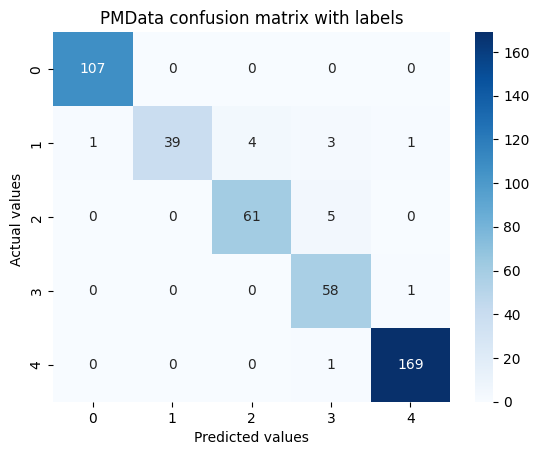

In [13]:
from sklearn.metrics import confusion_matrix

cor = confusion_matrix(y_test, y_pred_minirocket_multivariate_variable)

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cor, annot=True, cmap='Blues', fmt='d')
ax.set_title('PMData confusion matrix with labels')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values ')

fig = ax.get_figure()
fig.savefig('PMData_confusion_minirocket_multivariate_variable.png', dpi=300)
plt.show()

In [14]:
#Simulated MiniRocketVoting

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import RidgeClassifier
from sktime.transformations.panel.rocket import MiniRocketMultivariate
import numpy as np

# Create the MiniRocketMultivariate transformer
minirocket_transformer = MiniRocketMultivariate(num_kernels=10000)

# Transform the training and test data
X_train_transform = minirocket_transformer.fit_transform(X_train_padded, y_train)
X_test_transform = minirocket_transformer.transform(X_test_padded)

# Define base classifiers for the voting ensemble
clf1 = RidgeClassifier(alpha=1.0) # Example alpha value, can be tuned
clf2 = RidgeClassifier(alpha=0.1)
clf3 = RidgeClassifier(alpha=10.0)

# Create the Voting Classifier
voting_clf = VotingClassifier(estimators=[('ridge1', clf1), ('ridge2', clf2), ('ridge3', clf3)], voting='hard')

# Train the Voting Classifier on the transformed training data
voting_clf.fit(X_train_transform, y_train)

# Predict on the transformed test data
y_pred_minirocket_voting_simulated = voting_clf.predict(X_test_transform)

# Calculate the accuracy
accuracy_minirocket_voting_simulated = accuracy_score(y_test, y_pred_minirocket_voting_simulated)

# Calculate additional metrics
precision_minirocket_voting_simulated = precision_score(y_test, y_pred_minirocket_voting_simulated, average='micro')
recall_minirocket_voting_simulated = recall_score(y_test, y_pred_minirocket_voting_simulated, average='micro')
f1_minirocket_voting_simulated = f1_score(y_test, y_pred_minirocket_voting_simulated, average='weighted')
mcc_minirocket_voting_simulated = matthews_corrcoef(y_test, y_pred_minirocket_voting_simulated)


# Print the accuracy
print(f"Simulated MiniRocketVoting Classifier Accuracy: {accuracy_minirocket_voting_simulated}")
print(f"Simulated MiniRocketVoting Classifier Precision: {precision_minirocket_voting_simulated}")
print(f"Simulated MiniRocketVoting Classifier Recall: {recall_minirocket_voting_simulated}")
print(f"Simulated MiniRocketVoting Classifier F1-score: {f1_minirocket_voting_simulated}")
print(f"Simulated MiniRocketVoting Classifier MCC: {mcc_minirocket_voting_simulated}")

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.63756e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Simulated MiniRocketVoting Classifier Accuracy: 0.9666666666666667
Simulated MiniRocketVoting Classifier Precision: 0.9666666666666667
Simulated MiniRocketVoting Classifier Recall: 0.9666666666666667
Simulated MiniRocketVoting Classifier F1-score: 0.9664985621104651
Simulated MiniRocketVoting Classifier MCC: 0.955896548574838


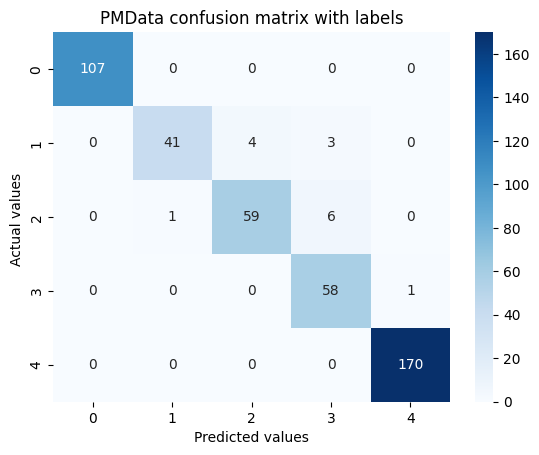

In [15]:
from sklearn.metrics import confusion_matrix

cor = confusion_matrix(y_test, y_pred_minirocket_voting_simulated)

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cor, annot=True, cmap='Blues', fmt='d')
ax.set_title('PMData confusion matrix with labels')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values ')

fig = ax.get_figure()
fig.savefig('PMData_confusion_minirocket_voting_simulated.png', dpi=300)
plt.show()

In [16]:
# Select 'steps' as the feature and 'active' as the label
X_uni = df_PMData[['steps']]
y_uni = df_PMData['active']

# Convert the feature column to a list of Series (nested format)
#X_uni = X_uni.apply(lambda x: pd.Series(x.values), axis=1)


# Split the data into training and testing sets
X_train_uni, X_test_uni, y_train_uni, y_test_uni = train_test_split(X_uni, y_uni, test_size=0.2, random_state=42)

display(X_train_uni.head())
display(y_train_uni.head())
display(X_test_uni.head())
display(y_test_uni.head())

,steps
478,10338.0
1247,3619.0
2100,2177.0
629,14021.0
1040,9040.0


,active
478,2
1247,0
2100,0
629,4
1040,1


,steps
940,15790.0
482,15853.0
581,6684.0
247,15195.0
1659,3950.0


,active
940,4
482,4
581,1
247,4
1659,0


In [17]:
#Rocket Classifier (Univariate)

from sktime.classification.kernel_based import RocketClassifier


performance_metrics_uni = {}

for feature in features:
    print(f"Training Rocket Classifier for feature: {feature}")

    # Select the current feature column for univariate analysis
    X_train_uni = X_train[[feature]]
    X_test_uni = X_test[[feature]]

    # Convert the feature column to a list of Series (nested format)
    X_train_uni_nested = X_train_uni.apply(lambda x: pd.Series(x.values), axis=1)
    X_test_uni_nested = X_test_uni.apply(lambda x: pd.Series(x.values), axis=1)

    # Reshape to 3D numpy array (n_samples, n_variables, n_timepoints)
    X_train_uni_reshaped = X_train_uni_nested.to_numpy().reshape(X_train_uni_nested.shape[0], 1, X_train_uni_nested.shape[1])
    X_test_uni_reshaped = X_test_uni_nested.to_numpy().reshape(X_test_uni_nested.shape[0], 1, X_test_uni_nested.shape[1])

    # Pad with zeros to have at least 9 timepoints if necessary
    padding_length = 9 - X_train_uni_reshaped.shape[2]
    if padding_length > 0:
        X_train_uni_padded = np.pad(X_train_uni_reshaped, ((0, 0), (0, 0), (0, padding_length)), mode='constant', constant_values=0)
        X_test_uni_padded = np.pad(X_test_uni_reshaped, ((0, 0), (0, 0), (0, padding_length)), mode='constant', constant_values=0)
    else:
        X_train_uni_padded = X_train_uni_reshaped
        X_test_uni_padded = X_test_uni_reshaped


    # Train Rocket Classifier
    rocket_classifier_uni = RocketClassifier(num_kernels=10000, random_state=42)
    rocket_classifier_uni.fit(X_train_uni_padded, y_train)

    # Predict on the test data
    y_pred_rocket_uni = rocket_classifier_uni.predict(X_test_uni_padded)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_rocket_uni)
    precision = precision_score(y_test, y_pred_rocket_uni, average='micro')
    recall = recall_score(y_test, y_pred_rocket_uni, average='micro')
    f1 = f1_score(y_test, y_pred_rocket_uni, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred_rocket_uni)

    performance_metrics_uni[feature] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1,
        "MCC": mcc
    }

    print(f" - Accuracy: {accuracy}")
    print(f" - Precision: {precision}")
    print(f" - Recall: {recall}")
    print(f" - F1-score: {f1}")
    print(f" - MCC: {mcc}")

# Create a pandas DataFrame from the dictionary
performance_df_uni = pd.DataFrame.from_dict(performance_metrics_uni, orient='index')

# Display the DataFrame
display(performance_df_uni)

Training Rocket Classifier for feature: steps
 - Accuracy: 0.39111111111111113
 - Precision: 0.39111111111111113
 - Recall: 0.39111111111111113
 - F1-score: 0.23444364372443702
 - MCC: 0.10815595288071793
Training Rocket Classifier for feature: sedentary
 - Accuracy: 0.37777777777777777
 - Precision: 0.37777777777777777
 - Recall: 0.37777777777777777
 - F1-score: 0.207168458781362
 - MCC: 0.0
Training Rocket Classifier for feature: LPA
 - Accuracy: 0.4311111111111111
 - Precision: 0.4311111111111111
 - Recall: 0.4311111111111111
 - F1-score: 0.3126243907524695
 - MCC: 0.18863888618450247
Training Rocket Classifier for feature: MPA
 - Accuracy: 0.5488888888888889
 - Precision: 0.5488888888888889
 - Recall: 0.5488888888888889
 - F1-score: 0.42898418886722983
 - MCC: 0.3918464285764406
Training Rocket Classifier for feature: VPA
 - Accuracy: 0.5533333333333333
 - Precision: 0.5533333333333333
 - Recall: 0.5533333333333333
 - F1-score: 0.4317966063475957
 - MCC: 0.3990234629858457


,Accuracy,Precision,Recall,F1-score,MCC
steps,0.391111,0.391111,0.391111,0.234444,0.108156
sedentary,0.377778,0.377778,0.377778,0.207168,0.000000
LPA,0.431111,0.431111,0.431111,0.312624,0.188639
MPA,0.548889,0.548889,0.548889,0.428984,0.391846
VPA,0.553333,0.553333,0.553333,0.431797,0.399023


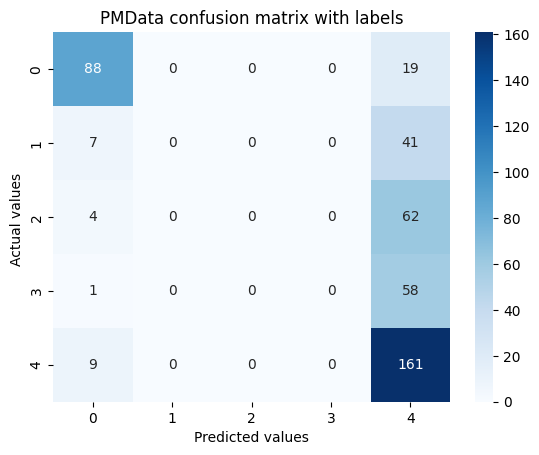

In [18]:
from sklearn.metrics import confusion_matrix

cor = confusion_matrix(y_test, y_pred_rocket_uni)

import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cor, annot=True, cmap='Blues', fmt='d')
ax.set_title('PMData confusion matrix with labels')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Actual values ')

fig = ax.get_figure()
fig.savefig('PMData_confusion_rocket.png', dpi=300)
plt.show()

In [19]:
import pandas as pd

# Retrieve the performance metrics for the last univariate feature processed in the previous cell (fPTNPsXSdEH2)
# This assumes the last feature processed (VPA in this case) is representative of the univariate Rocket results for comparison
accuracy_rocket_uni = performance_metrics_uni['steps']['Accuracy']
precision_rocket_uni = performance_metrics_uni['steps']['Precision']
recall_rocket_uni = performance_metrics_uni['steps']['Recall']
f1_rocket_uni = performance_metrics_uni['steps']['F1-score']
mcc_rocket_uni = performance_metrics_uni['steps']['MCC']


# Create a dictionary to store the performance metrics
performance_metrics = {
    "Classifier": ["Rocket (Univariate - steps)", "MiniRocketMultivariate", "MiniRocketMultivariateVariable", "Simulated MiniRocketVoting"],
    "Accuracy": [accuracy_rocket_uni, accuracy_minirocket_multivariate, accuracy_minirocket_multivariate_variable, accuracy_minirocket_voting_simulated],
    "Precision": [precision_rocket_uni, precision_minirocket_multivariate, precision_minirocket_multivariate_variable, precision_minirocket_voting_simulated],
    "Recall": [recall_rocket_uni, recall_minirocket_multivariate, recall_minirocket_multivariate_variable, recall_minirocket_voting_simulated],
    "F1-score": [f1_rocket_uni, f1_minirocket_multivariate, f1_minirocket_multivariate_variable, f1_minirocket_voting_simulated],
    "MCC": [mcc_rocket_uni, mcc_minirocket_multivariate, mcc_minirocket_multivariate_variable, mcc_minirocket_voting_simulated]
}

# Create a pandas DataFrame from the dictionary
performance_df = pd.DataFrame(performance_metrics)

# Display the DataFrame
display(performance_df)

,Classifier,Accuracy,Precision,Recall,F1-score,MCC
0,Rocket (Univariate - steps),0.391111,0.391111,0.391111,0.234444,0.108156
1,MiniRocketMultivariate,0.966667,0.966667,0.966667,0.966640,0.955988
2,MiniRocketMultivariateVariable,0.964444,0.964444,0.964444,0.964054,0.953023
3,Simulated MiniRocketVoting,0.966667,0.966667,0.966667,0.966499,0.955897
